# Batch size, Optimizers, Loss

We will study the behaviour of batch size, optimizers, and loss on a linear regression, as it makes the parameters easy to visualize.

---

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Fake data & basic linear regression

We create some random points roughly aligned, so we can perform a linear regression.

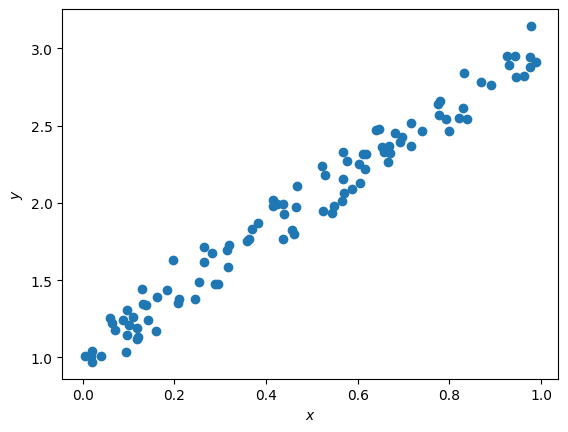

In [2]:
np.random.seed(0)

XS = np.random.rand(100, 1)
YS = 1 + 2 * XS + .1 * np.random.randn(100, 1)

plt.scatter(XS, YS)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

A linear regression is a simple model, where $y_{pred} = a*x+b$.
The loss (function we try to minimize) is usually the mean squared error $\mathcal{L}(a,b) = \sum_{i=1}^N ({y_{pred}}_i-y_i)^2 = \sum_{i=1}^N ((ax_i+b)-y_i)^2$.

Let's define a function that calculates the loss for $a \in \left[0,2\right]$ and $b \in \left[-1,3\right]$ (with a grid of $100 \times 100$ points), and plot the loss on that range.

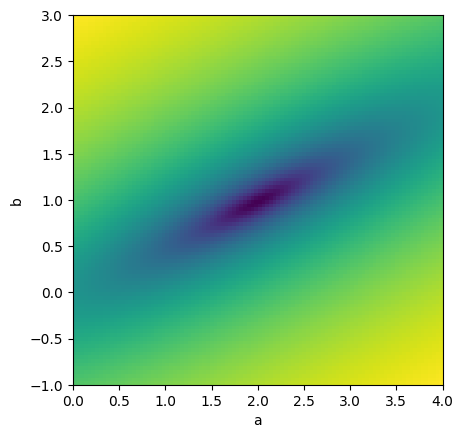

In [3]:
def loss_map(xs, ys):
    aa = np.linspace(0,4, 100)
    bb = np.linspace(-1,3, 100)
    A, B = np.meshgrid(aa, bb)
    L = np.zeros((100,100))
    for i in range(100):
        for j in range(100):
            a = A[i,j]
            b = B[i,j]
            yhat = a*xs + b
            L[i,j] = np.log(np.mean((ys-yhat)**2))
    return L

L = loss_map(XS, YS)
plt.imshow(L, extent=[0, 4, -1, 3])
plt.xlabel('a')
plt.ylabel('b')
plt.show()

We then create a tensor dataset from our points

In [4]:
XS_T = torch.from_numpy(XS).float()
YS_T = torch.from_numpy(YS).float()
dataset = TensorDataset(XS_T, YS_T)
dataset[0]

(tensor([0.5488]), tensor([1.9811]))

We create a `nn.Module` (a model) that is a linear function

In [5]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.b + self.a * x

Here is an example of training for our linear model.
On top of training, this cell also stores the evolution of values of $a$ and $b$ over time.

In [6]:
train_loader = DataLoader(dataset=dataset, batch_size=100)
torch.manual_seed(42)
model = LinearModel().to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=0.05)
a_s = [model.a.item()]
b_s = [model.b.item()]
t_s = [0]
t = time.time()
for epoch in range(1000):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_batch_hat = model(x_batch)
        loss = loss_fn(y_batch, y_batch_hat)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        a_s.append(model.a.item())
        b_s.append(model.b.item())
        t_s.append(time.time() - t)

Here is a code to plot the evolution of $a$ and $b$ over time, and in the loss space:

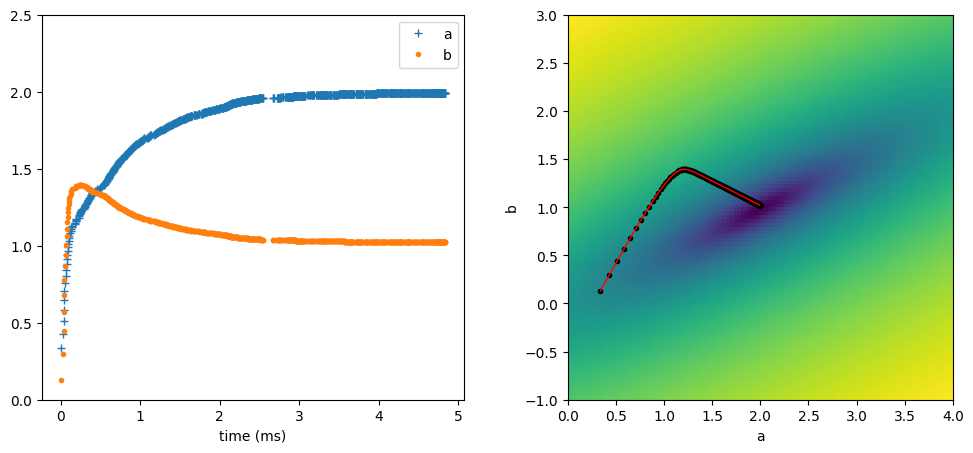

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(t_s, a_s, '+', label='a')
plt.plot(t_s, b_s, '.', label='b')
plt.legend()
plt.ylim(min(0, min(a_s),min(b_s)), max(2.5, max(a_s),max(b_s)))
plt.xlabel("time (ms)")
plt.subplot(122)
plt.imshow(L, extent=[0, 4, -1, 3])
plt.plot(a_s, b_s, "k.")
plt.plot(a_s, b_s, 'r', lw=1)
plt.xlim(0, 4)
plt.ylim(-1, 3)
plt.xlabel("a")
plt.ylabel("b")
plt.show()

Combining the two cells above, create a function `plot_training` that create the two plots above.
The function should have arguments `n_epochs` (the number of epochs), `lr` (the learning rate), and `batch_size` (the size of the batches).
This function should also return the value of the parameters $a$ and $b$ at the end of the training.

In [8]:
def plot_training(n_epochs, lr, batch_size):
    pass

plot_training(n_epochs=1000, lr=0.05, batch_size=100)

---

## Batch size

Try `n_epochs=10`, `lr=0.1`, `batch_size=100` this will be our basis, to be improved.

Increase the number of epoch untill convegrence is reached.

Let `lr=0.5`. How many epoch do you now need to reach convergence?

Could we use even less epochs by increasing the learning rate even more?

Let `lr=1`. Can you reach convergence?

Let `lr=0.5` again; 
Let's modify the batch size by putting `batch_size=5`.

How many epochs are now needed to reach convergence?

The solution appears to be very unstable, let's lower the learning rate in order to have more stability.

Put `lr=0.05`.
How many epochs are now needed to converge?

Should we lower even more the learning rate?

Put `lr=0.005`.
How many epochs are now needed to converge?

You can see that:
- the larger the learning rate, the faster we converge
- a learning rate too large causes divergence
- a learning rate too low will converge, but (extremely) slowly;
- the bigger the batch size, the more stable our solution is
- a batch size too large may not fit in our memory (here, the full dataset is just two lists of 100 points, but if the dataset was composed of 10000 or 100000 images, then we would be forced to use a smaller batch size)
- a batch size too low makes the gradient very unstable, and therefore convergence is harder to reach.

The rules of thumb are:
* When you lower the batch size, lower the learning rate aw well
* When you increase the batch size, you can afford to increase the learning rate;
* Batch size as large as possible, given you memory (so that we increase stability of the gradient descend)
* Try various learning rates by hand, pick the largest one that does not diverge.

---

## Optimizer

Let's try to add momentum.

Modify your `plot_training` function to incorporate a new parameter: `momentum`, that you give to SGD.

In [9]:
def plot_training(n_epochs, lr, batch_size, momentum=0):
    pass

Set `n_epochs=150`, `lr=0.2`, `batch_size=100`.

Test how many epochs are needed to converge for the following momentum values:
- `momentum=0`
- `momentum=0.3`
- `momentum=0.7`
- `momentum=0.9`
- `momentum=1`
- `momentum=1.1`

Rule of thumb: **Typically, we set momentum in $\left[ 0.7, 0.9 \right]$.**

---

Adam is an optimizer that adapts the learning rate ot each parameter. It also has a momentum included by default.

Change your `plot_hyper` function to include a parameter `adam` that may be set to true/false if we want to use Adam.

In [10]:
def plot_training(n_epochs, lr, batch_size, momentum=0, adam=False):
    pass

Run an optimization with adam optimizer
```
plot_training(n_epochs=100, lr=0.2, batch_size=100, adam=True)
```

Adam has two parameters for the momentum (the "betas").
You can try to play with it, but keep in mind that 99.9% of the time, we use the default parameters.

Rule of thumb: **Most people are to lazy to find the perfect momentum; so most of the time, we just use Adam.**

---

## Loss

The loss function does not change the speed of convergence, but the point to which we converge.

Let's add an `error_power` parameter to our `calc_loss` function.
By default, we take the mean square error, but settin this parameter to 1 should take the mean absolute error, and setting it to 3 should take the mean absolute cubic error.

In [11]:
def loss_map(xs, ys, pow_err=2):
    aa = np.linspace(0,4, 100)
    bb = np.linspace(-1,3, 100)
    A, B = np.meshgrid(aa, bb)
    L = np.zeros((100,100))
    for i in range(100):
        for j in range(100):
            a = A[i,j]
            b = B[i,j]
            yhat = a*xs + b
            L[i,j] = np.log(np.mean(np.abs(ys-yhat)**pow_err))
    return L

Use this to plot MSE and MAE

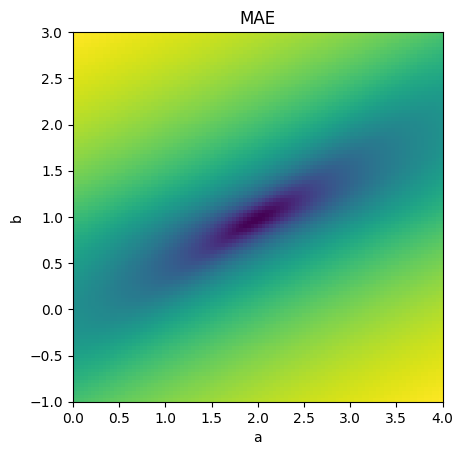

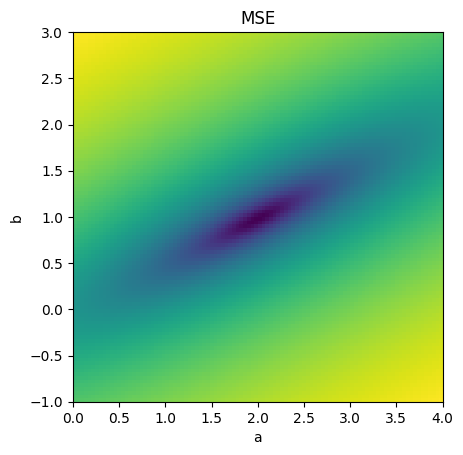

In [12]:
L = loss_map(XS, YS, 1)
plt.imshow(L, extent=[0, 4, -1, 3])
plt.xlabel('a')
plt.ylabel('b')
plt.title('MAE')
plt.show()

L = loss_map(XS, YS, 2)
plt.imshow(L, extent=[0, 4, -1, 3])
plt.xlabel('a')
plt.ylabel('b')
plt.title('MSE')
plt.show()

Let's change a bit the data, so that we can see better what changes.
Rerun using the following $XS$ nad $YS$.

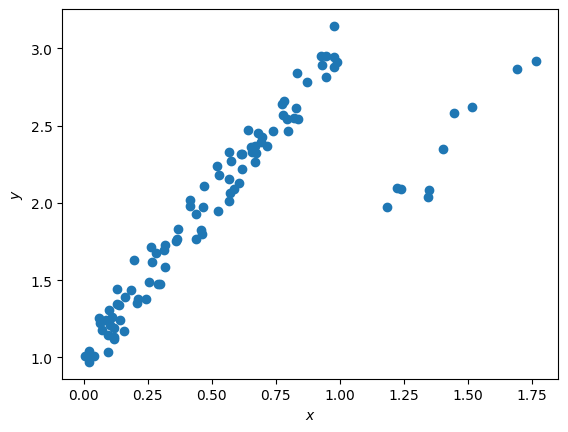

In [13]:
np.random.seed(0)
XS = np.random.rand(100, 1)
XS[:10] += 0.8
YS = 1 + 2 * XS + .1 * np.random.randn(100, 1)
YS[:10] -= 1.5
XS_T = torch.from_numpy(XS).float()
YS_T = torch.from_numpy(YS).float()
dataset = TensorDataset(XS_T, YS_T)

plt.scatter(XS, YS)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

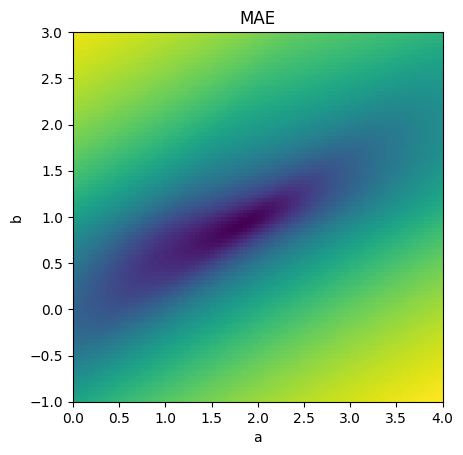

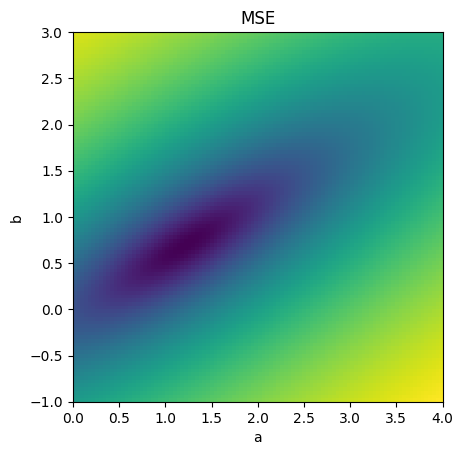

In [14]:
L = loss_map(XS, YS, 1)
plt.imshow(L, extent=[0, 4, -1, 3])
plt.xlabel('a')
plt.ylabel('b')
plt.title('MAE')
plt.show()

L = loss_map(XS, YS, 2)
plt.imshow(L, extent=[0, 4, -1, 3])
plt.xlabel('a')
plt.ylabel('b')
plt.title('MSE')
plt.show()

Modifiy the `plot_training` function, to include the parameter `error_power`. Also, rename the function `training` and stop plotting, as we now just want to compare the values of $a$ and $b$ (after the model has converged).

In [15]:
def training(n_epochs, lr, batch_size, pow_err=2):
    pass

Compute optimized parameters $a$ and $b$ for `pow_err` of $1$, $2$, and $5$.
Plot the three linear models together with a scatter of the data.

The greater the power, the more the model is affected by extreme values.
Depending on the application, this may be more or less desirable.

Rule of thumbs: **Use MSE** (i.e. `pow_err=2`)